<a href="https://colab.research.google.com/github/CalculatedContent/xgboost2ww/blob/main/XGBoost2WWDiagnosticExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# ============================================================
# xgboost2ww Diagnostic Example Notebook (ONE CELL, copy/paste)
#
# This notebooks demos an overly simple model where the training data
# is strongly overfit (similar to Grokking in Modular Addition) and
# distorts the PL fit for alpha
# BUT
# Checking the detX condition, we see the model is actually optimal
# (last cell, last plot, purple and red lines overlap)
#
# Goal (simple + realistic + fast):
#   - Train a strong XGBoost binary classifier on a non-trivial dataset
#   - Compute WeightWatcher diagnostics on XGBoost using xgboost2ww.convert()
#   - Confirm:
#       (1) Train/test accuracy is high
#       (2) alpha(W7) is 1.6 , a bit overfit
#       (3) traps(W7) is ~0
#       (4) detX condition is near perfect
#
# Dataset choice:
#   - OpenML "kr-vs-kp" (OpenML id=3): chess endgame positions
#   - Non-trivial, but not huge; typically trains fast and generalizes well
#   - Minimal preprocessing: impute missing + one-hot encode categoricals
#
# Notes:
#   - We use a true holdout test set (never used for CV/OOF/WW).
#   - We pick hyperparams via a small training-only CV sweep with early stopping.
#   - We compute ONLY W7 (usually the most diagnostic matrix).
#   - WeightWatcher call does NOT require detX=True for an initial eval.
#
#   - While the alpha < 2, the detX condition is nearly perfect,indicating that
#     it can be difficult to get good PL fits in these kinds of models
# ============================================================

!pip -q install "pandas==2.2.2" xgboost weightwatcher scikit-learn openml scipy pyarrow
!apt-get -qq update && apt-get -qq install -y git

# --- Clone + install xgboost2ww (public repo) ---
!rm -rf /content/xgboost2ww
!git clone https://github.com/CalculatedContent/xgboost2ww.git /content/xgboost2ww
!pip -q install -e /content/xgboost2ww

# --- Fix Colab namespace-cache issues (safe to run always) ---
import sys
sys.path.insert(0, "/content/xgboost2ww/src")
sys.modules.pop("xgboost2ww", None)

import xgboost2ww
print("xgboost2ww loaded from:", getattr(xgboost2ww, "__file__", None))
from xgboost2ww import convert
print("Imported xgboost2ww.convert OK")

# --- Imports ---
import warnings, time
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import xgboost as xgb
import openml

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, log_loss

import torch
import weightwatcher as ww
import matplotlib.pyplot as plt

# ============================================================
# Settings (simple + fast)
# ============================================================
RNG = 0
rng = np.random.default_rng(RNG)

OPENML_ID = 3                 # kr-vs-kp
TEST_SIZE = 0.20
NFOLDS = 5
T_TRAJ = 160

GOOD_TRIALS = 3               # small sweep (fast)
CV_MAX_ROUNDS = 800           # smaller than your big runs, still enough
CV_EARLY_STOP = 60

# ============================================================
# 1) Load dataset (simple preprocessing)
# ============================================================
ds = openml.datasets.get_dataset(OPENML_ID)
target = ds.default_target_attribute
Xdf, y_raw, _, _ = ds.get_data(dataset_format="dataframe", target=target)
print(f"Loaded OpenML {OPENML_ID}: {ds.name} | rows={len(Xdf)} cols={Xdf.shape[1]}")

# Factorize labels to {0,1}
y, uniques = pd.factorize(y_raw)
y = y.astype(np.int32)
if len(uniques) != 2:
    raise ValueError(f"Expected binary dataset; got {len(uniques)} classes: {list(uniques)}")

# Simple preprocessing: impute + one-hot categoricals
cat_cols = Xdf.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
num_cols = [c for c in Xdf.columns if c not in cat_cols]

pre = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
        ]), cat_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3,
)

X = pre.fit_transform(Xdf)

# Convert sparse -> dense for simplicity + compatibility (dataset is small)
if hasattr(X, "toarray"):
    X = X.toarray()
X = np.asarray(X, dtype=np.float32)

print("After preprocessing:", X.shape, X.dtype)

# ============================================================
# 2) True holdout split (test never used for CV/OOF/WW)
# ============================================================
idx = np.arange(len(y))
tr_idx, te_idx = train_test_split(idx, test_size=TEST_SIZE, random_state=RNG, stratify=y)

Xtr, ytr = X[tr_idx], y[tr_idx]
Xte, yte = X[te_idx], y[te_idx]
print(f"Train: {Xtr.shape} | Test: {Xte.shape}")

# ============================================================
# 3) Pick "good" hyperparams via training-only CV (fast sweep)
# ============================================================
def pick_good_params_via_cv(Xtr, ytr):
    dtrain = xgb.DMatrix(Xtr, label=ytr)
    local_rng = np.random.default_rng(RNG + OPENML_ID)

    best = None
    best_score = np.inf

    for t in range(GOOD_TRIALS):
        params = dict(
            objective="binary:logistic",
            eval_metric="logloss",
            tree_method="hist",
            seed=RNG,
            learning_rate=float(10 ** local_rng.uniform(-2.0, -0.4)),  # ~0.01..0.4
            max_depth=int(local_rng.integers(2, 6)),
            min_child_weight=float(10 ** local_rng.uniform(0.0, 1.5)), # ~1..31
            subsample=float(local_rng.uniform(0.7, 0.95)),
            colsample_bytree=float(local_rng.uniform(0.7, 0.95)),
            reg_lambda=float(10 ** local_rng.uniform(0.0, 2.0)),       # ~1..100
            gamma=float(local_rng.uniform(0.0, 0.3)),
        )

        cv = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=CV_MAX_ROUNDS,
            nfold=NFOLDS,
            stratified=True,
            early_stopping_rounds=CV_EARLY_STOP,
            seed=RNG,
            verbose_eval=False,
        )

        score = float(cv["test-logloss-mean"].iloc[-1])
        rounds = int(len(cv))
        if score < best_score:
            best_score = score
            best = (params, rounds, score)

    return best

good_params, good_rounds, good_cv_logloss = pick_good_params_via_cv(Xtr, ytr)
print("Selected rounds:", good_rounds, "| CV logloss:", good_cv_logloss)
print("Selected params (key subset):",
      {k: good_params[k] for k in ["learning_rate","max_depth","subsample","colsample_bytree","reg_lambda","gamma"]})

# ============================================================
# 4) Train final model on TRAIN and evaluate on HOLDOUT
# ============================================================
dtr = xgb.DMatrix(Xtr, label=ytr)
dte = xgb.DMatrix(Xte, label=yte)

bst = xgb.train(params=good_params, dtrain=dtr, num_boost_round=good_rounds, verbose_eval=False)

m_tr = bst.predict(dtr, output_margin=True).astype(np.float32)
p_tr = 1.0 / (1.0 + np.exp(-m_tr))
train_acc = float(accuracy_score(ytr, (p_tr >= 0.5).astype(np.int32)))

m_te = bst.predict(dte, output_margin=True).astype(np.float32)
p_te = 1.0 / (1.0 + np.exp(-m_te))
test_acc = float(accuracy_score(yte, (p_te >= 0.5).astype(np.int32)))
test_loss = float(log_loss(yte, np.vstack([1 - p_te, p_te]).T, labels=[0, 1]))

print(f"Train acc: {train_acc:.4f} | Test acc: {test_acc:.4f} | Test logloss: {test_loss:.4f}")

# ============================================================
# 5) Compute W7 via xgboost2ww.convert() and run WeightWatcher
# ============================================================
# IMPORTANT for reproducibility:
#   train_params=good_params, num_boost_round=good_rounds
# so the OOF fold-training matches the chosen model configuration exactly.
layer_W7 = convert(
    model=bst,
    data=Xtr,
    labels=ytr,
    W="W7",
    nfolds=NFOLDS,
    t_points=T_TRAJ,
    random_state=RNG,
    train_params=good_params,
    num_boost_round=good_rounds,
    multiclass="error",
    return_type="torch",
    verbose=False,
)

watcher = ww.WeightWatcher(model=layer_W7)
details_df = watcher.analyze(randomize=True, plot=False)  # starter: no detX needed

alpha = float(details_df["alpha"].iloc[0]) if "alpha" in details_df.columns else float("nan")
traps = float(details_df["rand_num_spikes"].iloc[0]) if "rand_num_spikes" in details_df.columns else float("nan")

print("\nWeightWatcher Diagnostics (W7)")
print("  alpha (ideal ~2):", alpha)
print("  traps (ideal 0): ", traps)

# Simple heuristic interpretation for the demo
if np.isfinite(alpha):
    if abs(alpha - 2.0) < 0.35 and traps <= 0:
        verdict = "✅ Looks well-structured (alpha ~ 2, traps ~ 0)"
    elif alpha < 2.0 or traps > 0:
        verdict = "🚨 Potential overfit/memorization (alpha < 2 and/or traps > 0)"
    elif alpha > 2.0:
        verdict = "⚠️ Suboptimal structure (alpha > 2)"
    else:
        verdict = "⚠️ Mixed signal"
else:
    verdict = "⚠️ alpha not computed (check WeightWatcher output)"
print("  verdict:", verdict)


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Cloning into '/content/xgboost2ww'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 59 (delta 24), reused 21 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (59/59), 308.09 KiB | 3.54 MiB/s, done.
Resolving deltas: 100% (24/24), done.
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for xgboost2ww (pyproject.toml) ... done
xgboost2ww loaded from: /content/xgboost2ww/src/xgboost2ww/__init__.py
Imported xgboost2ww.convert OK
Loaded OpenML 3: kr-vs-kp | rows=3196 cols=36
After preprocessing: (3196, 73) float32
Train: 

# WeightWatcher Diagnostics

From the $\alpha=1.6$, the model looks overfit, but the detX condition is very good (purple and red lines nearly overlap)

This is an example of where the PL fit for $\alpha$ is distorted because the training data is strongly memorized .

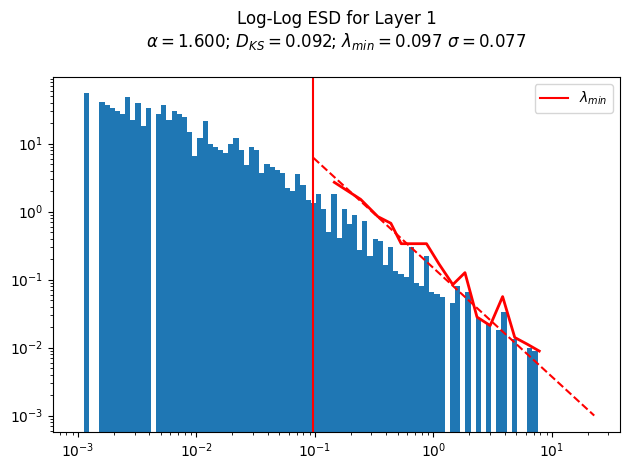

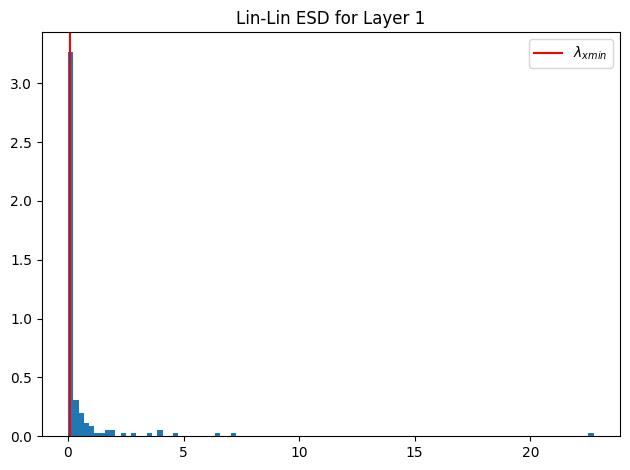

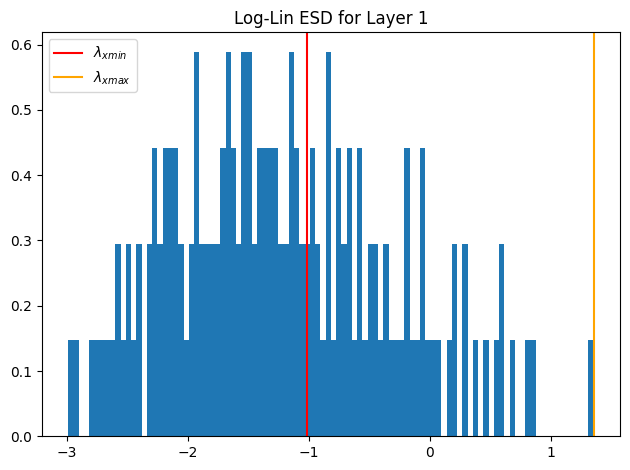

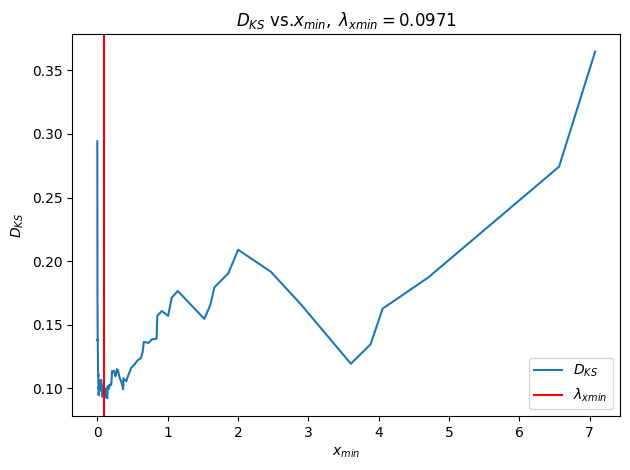

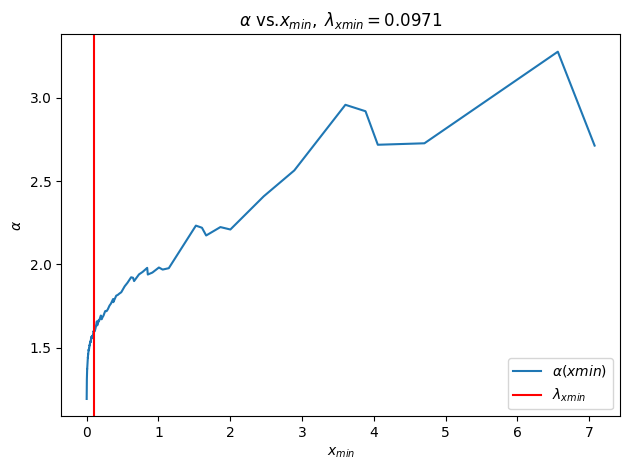

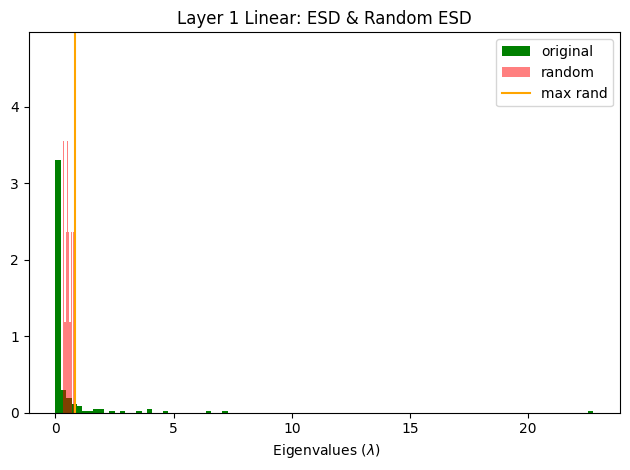

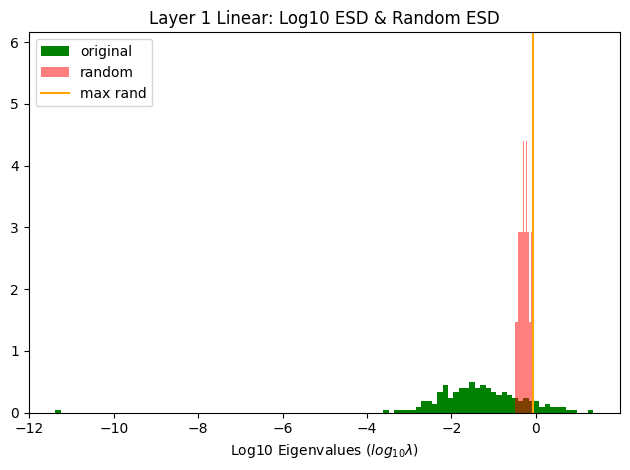

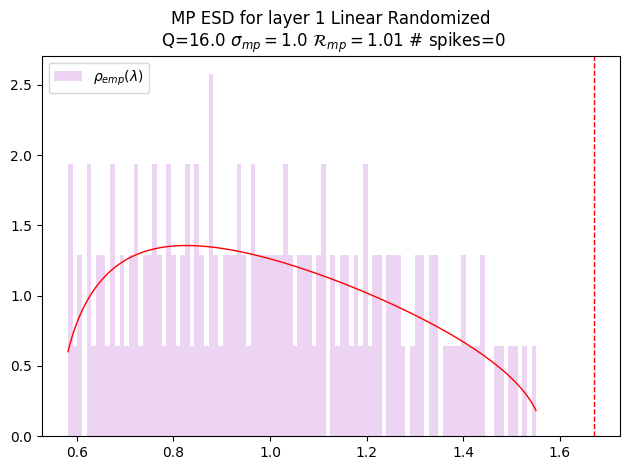

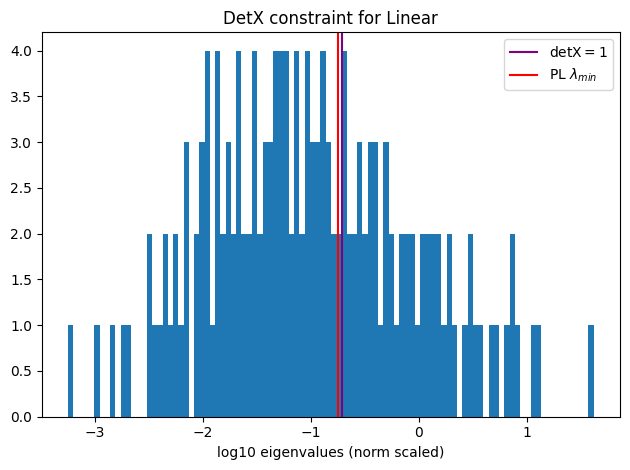

<Figure size 640x480 with 0 Axes>

In [6]:
details_df = watcher.analyze(randomize=True, plot=True, detX=True)

In [ ]:
H